# The Future is Now: Patterns in Global Temperature Trends Across the World

Continued from `Analysis 3 Cluster Hierarchical.ipynb`.

## Dependency Installation & Imports

In [1]:
%pip install pandas numpy scikit-learn matplotlib missingno pyarrow pycountry_convert kgcpy scipy fastdtw statsmodels networkx pyvis

Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', None)
global_correlation = 0.895059831369191

## Further Pattern Examination

### Data Preparation (Standardization)

In [3]:
with open('Data_augmented.csv', 'r', encoding='utf-8') as file:
    df = pd.read_csv(file, encoding='utf-8')

df.head()

,City,Year,AverageTemperature,Country,Latitude,Longitude,NumericLatitude,NumericLongitude,AbsLatitude,AbsLongitude,Continent,kcc
0,A Coruña,1880,12.837750,Spain,43.3709703N,8.3959425W,43.37097,-8.395943,43.37097,8.395943,Europe,Csb
1,A Coruña,1881,13.405000,Spain,43.3709703N,8.3959425W,43.37097,-8.395943,43.37097,8.395943,Europe,Csb
2,A Coruña,1882,12.776250,Spain,43.3709703N,8.3959425W,43.37097,-8.395943,43.37097,8.395943,Europe,Csb
3,A Coruña,1883,12.260833,Spain,43.3709703N,8.3959425W,43.37097,-8.395943,43.37097,8.395943,Europe,Csb
4,A Coruña,1884,12.693250,Spain,43.3709703N,8.3959425W,43.37097,-8.395943,43.37097,8.395943,Europe,Csb


### Model-Based Clustering with Gaussian Mixture Models (GMMs)

In [4]:
def calculate_corr(df):
    corr_matrix = df[['Year', 'AverageTemperature']].corr()
    return corr_matrix.loc['Year', 'AverageTemperature']

grouped = df.groupby(['City', 'Country']).apply(calculate_corr).reset_index(name='corr')

df = df.merge(grouped, on=['City', 'Country'], how='left')

scaler = MinMaxScaler()
df['AbsLatitude_scaled'] = scaler.fit_transform(df[['AbsLatitude']])

clustering_df = df[['City', 'Country', 'corr', 'AbsLatitude_scaled']].drop_duplicates()

X = clustering_df[['corr', 'AbsLatitude_scaled']].values

C:\Users\jacob\AppData\Local\Temp\ipykernel_28864\1584961914.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(['City', 'Country']).apply(calculate_corr).reset_index(name='corr')


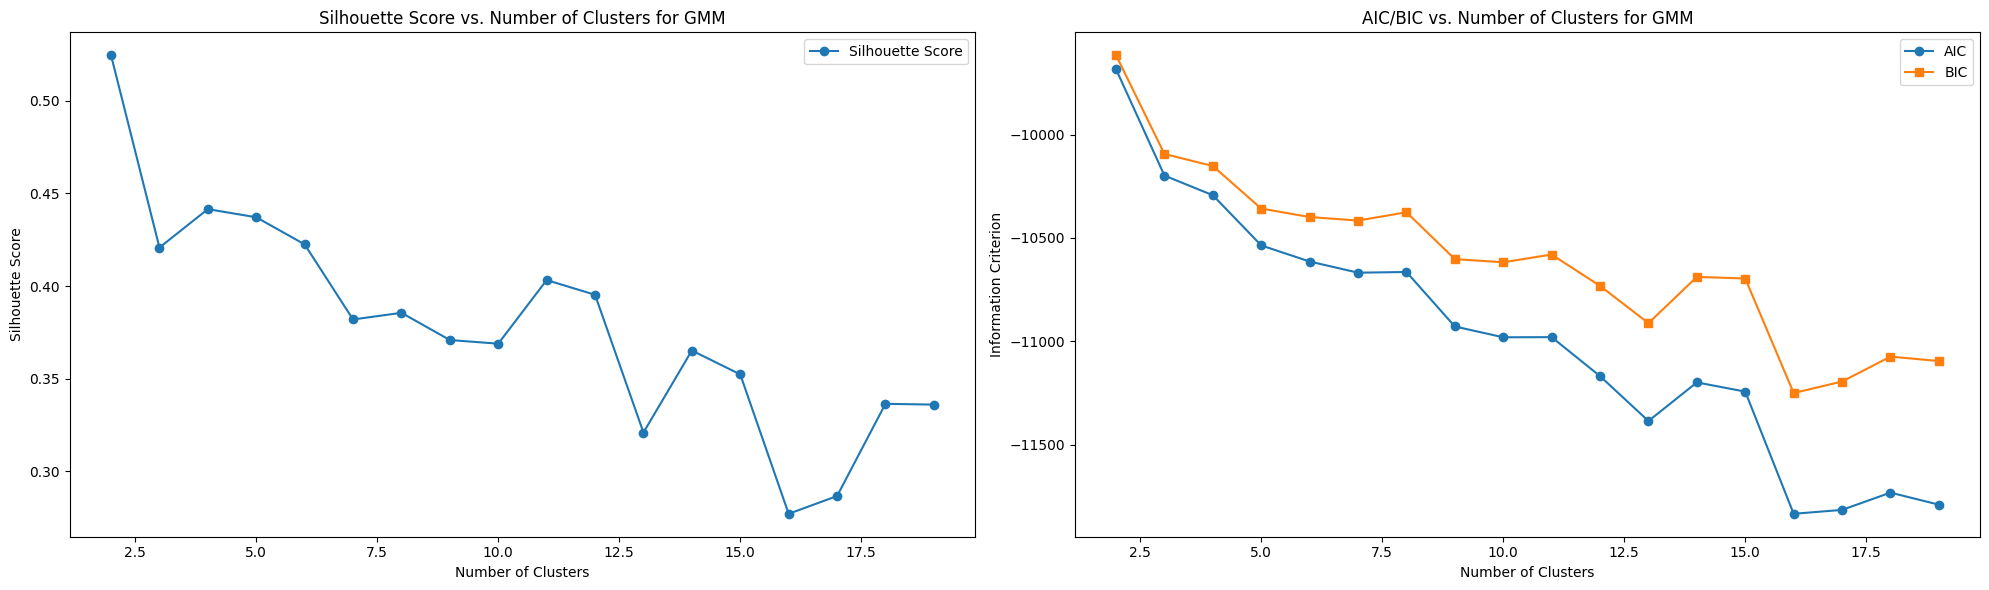

In [5]:
# Silhouette score plot & AIC/BIC plot
silhouette_scores = []
aic_scores = []
bic_scores = []

for n_clusters in range(2, 20):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)
    aic_scores.append(gmm.aic(X))
    bic_scores.append(gmm.bic(X))

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].plot(range(2, 20), silhouette_scores, marker='o', label='Silhouette Score')
axs[0].set_title('Silhouette Score vs. Number of Clusters for GMM')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
axs[0].legend()

axs[1].plot(range(2, 20), aic_scores, marker='o', label='AIC')
axs[1].plot(range(2, 20), bic_scores, marker='s', label='BIC')
axs[1].set_title('AIC/BIC vs. Number of Clusters for GMM')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Information Criterion')
axs[1].legend()

plt.tight_layout()
plt.show()

In [6]:
n_clusters = 5 
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(X)
labels = gmm.predict(X)

clustering_df['Cluster'] = labels
df_merged = pd.merge(df, clustering_df[['City', 'Country', 'Cluster']], on=['City', 'Country'], how='left')

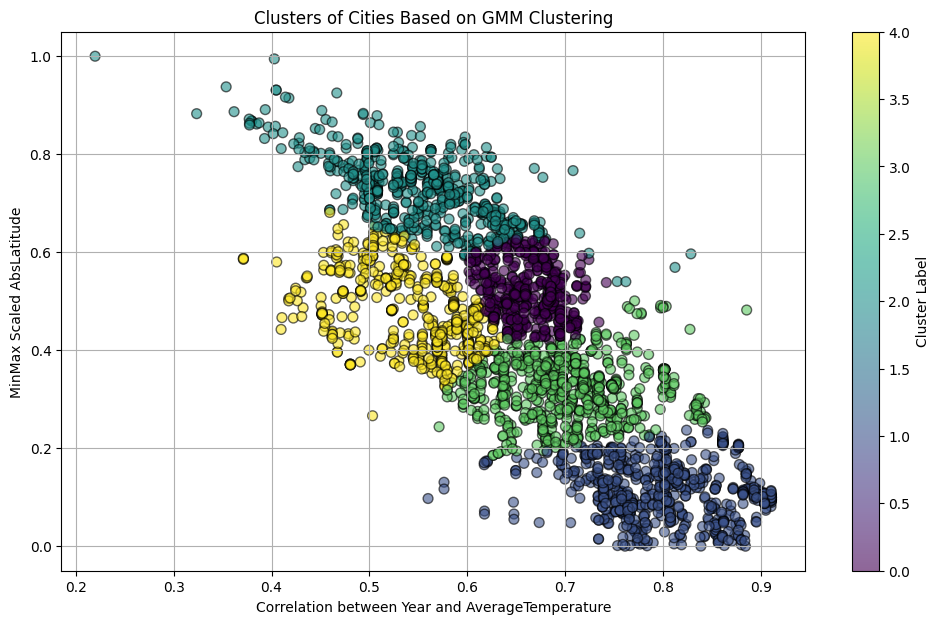

In [8]:
# Clustering visualization
plt.figure(figsize=(12, 7))

plt.scatter(clustering_df['corr'], clustering_df['AbsLatitude_scaled'], c=clustering_df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)

plt.title('Clusters of Cities Based on GMM Clustering')
plt.xlabel('Correlation between Year and AverageTemperature')
plt.ylabel('MinMax Scaled AbsLatitude')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

In [11]:
# Cluster metrics
silhouette_avg = silhouette_score(X, labels)
calinski_harabasz = calinski_harabasz_score(X, labels)
davies_bouldin = davies_bouldin_score(X, labels)

print(f'Silhouette Score for {n_clusters} clusters: {silhouette_avg:.2f}')
print(f'Calinski-Harabasz Index: {calinski_harabasz:.2f}')
print(f'Davies-Bouldin Index: {davies_bouldin:.2f}')

Silhouette Score for 5 clusters: 0.44
Calinski-Harabasz Index: 6558.63
Davies-Bouldin Index: 0.84


In [28]:
df_unique_cities = df.drop_duplicates(subset='City')[['City', 'Country', 'Continent', 'kcc', 'corr', 'NumericLatitude', 'NumericLongitude']]
df_merged = pd.merge(df_merged, df_unique_cities, on='City', how='left')

In [14]:
df_gmm = df_merged[['Country', 'NumericLatitude', 'NumericLongitude', 'Continent', 'kcc', 'City', 'Cluster']].copy()
df_gmm.drop_duplicates(subset=['City', 'Country'], inplace=True)
df_gmm = df_gmm.sort_values(by=['Cluster', 'City']).reset_index(drop=True)

outfile = 'Data_gmm.csv'
df_gmm.to_csv(outfile, index=False)

print(f'Exported gmm-clustered cities to {outfile}')

Exported gmm-clustered cities to Data_gmm.csv


#### Cluster Visualizations

1. Unique Cities in each cluster
2. Unique Countries in each cluster
3. Proportion of Continents in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
4. Proportion of climates in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
5. For each cluster:
   1. Averaged AverageTemperature by Year & correlations
   2. AverageTemperature by Year & correlations
   3. Box & Whiskers plots to look at geographic spread (Latitude, Longitude)

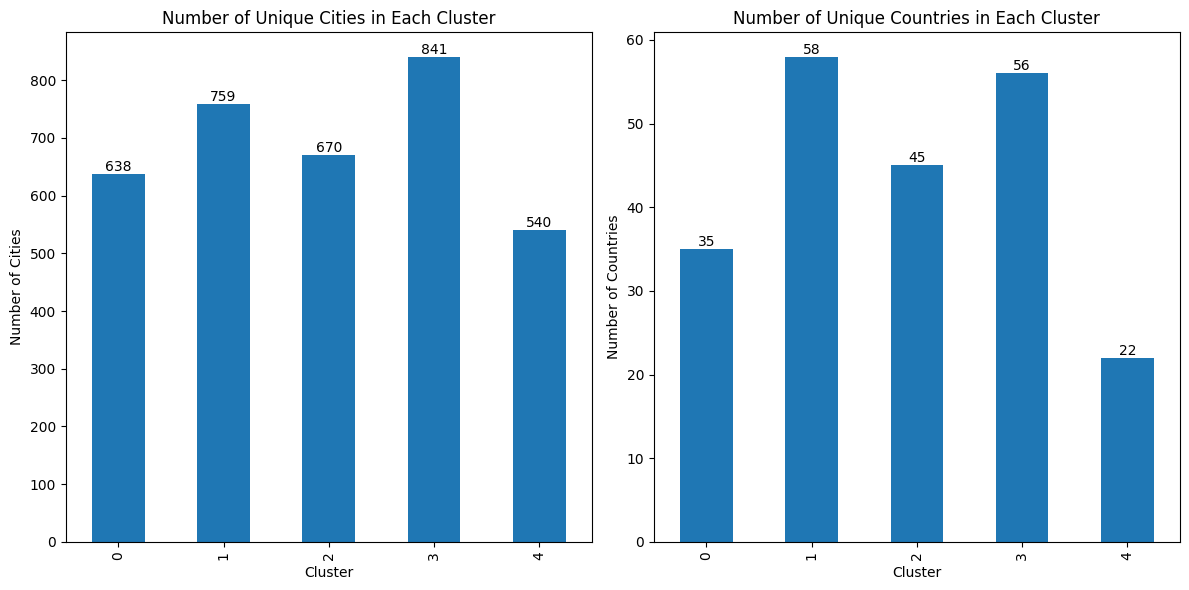

In [15]:
# Unique cities and countries in each cluster
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cities_per_cluster = df_merged.groupby('Cluster')['City'].nunique()
cities_per_cluster.plot(kind='bar')
plt.title('Number of Unique Cities in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Cities')
for index, value in enumerate(cities_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.subplot(1, 2, 2)
countries_per_cluster = df_merged.groupby('Cluster')['Country'].nunique()
countries_per_cluster.plot(kind='bar')
plt.title('Number of Unique Countries in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Countries')
for index, value in enumerate(countries_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Visualization & correlation of averaged clusters

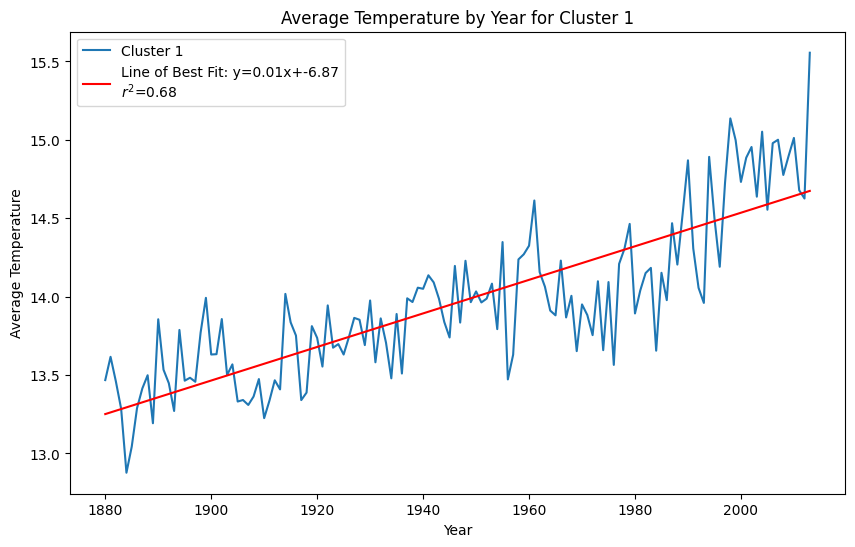

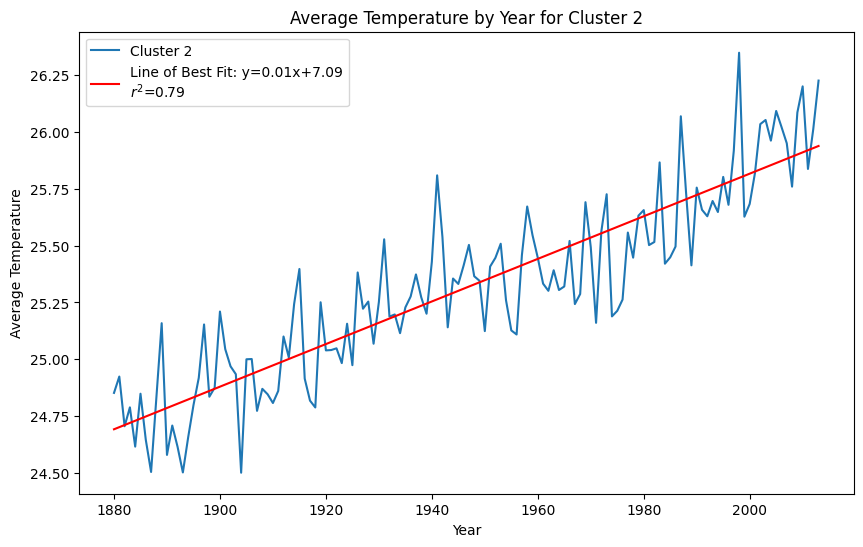

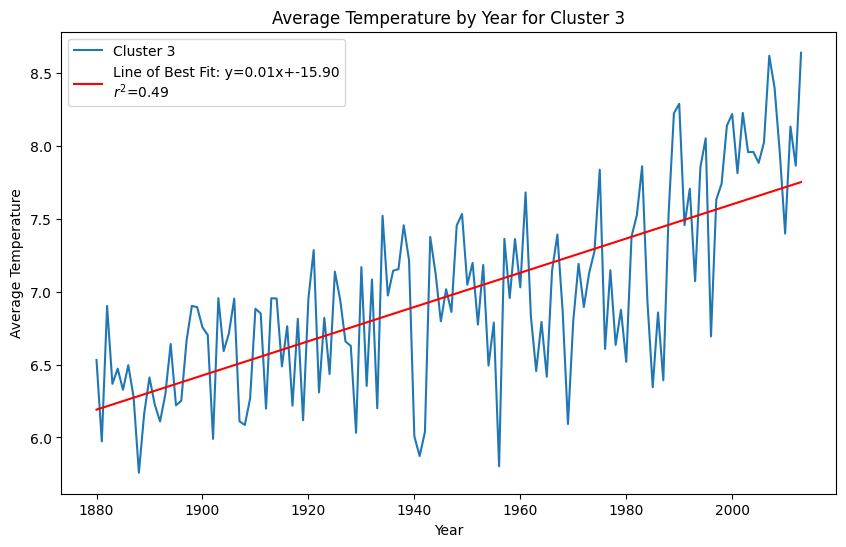

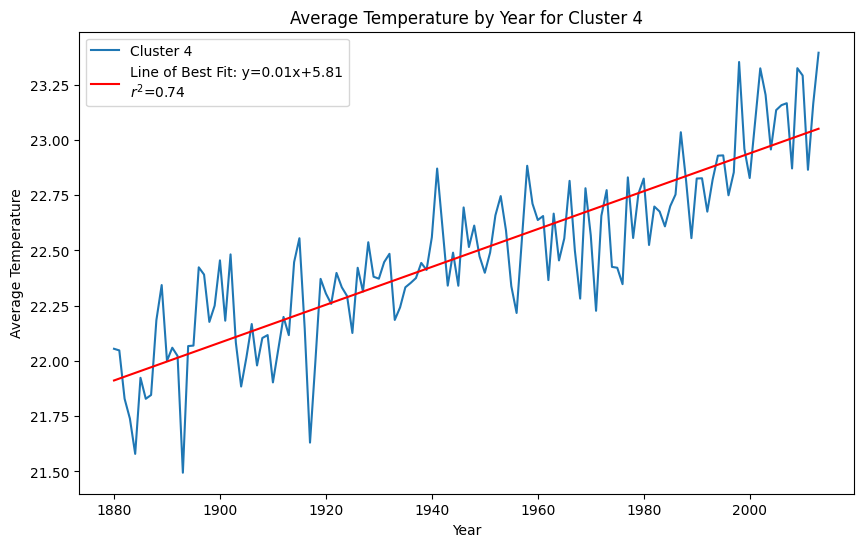

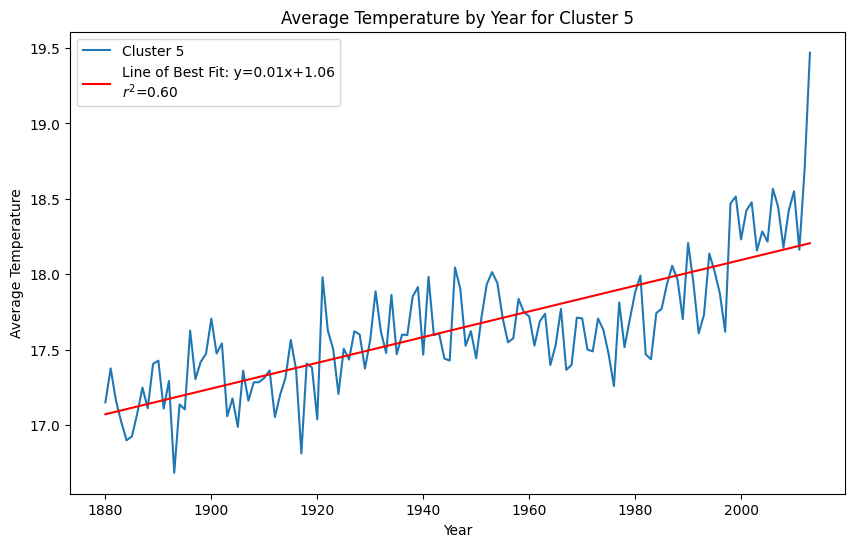

In [16]:
n_clusters = np.sort(df_merged['Cluster'].unique())

for cluster in n_clusters:
    cluster_data = df_merged[df_merged['Cluster'] == cluster]
    year_temperature = cluster_data.groupby('Year')['AverageTemperature'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.plot(year_temperature['Year'], year_temperature['AverageTemperature'], label=f'Cluster {cluster+1}')
    
    # Line of best fit
    slope, intercept, r_value, _, _ = linregress(year_temperature['Year'], year_temperature['AverageTemperature'])
    line = slope * year_temperature['Year'] + intercept
    plt.plot(year_temperature['Year'], line, 'r', label=f'Line of Best Fit: y={slope:.2f}x+{intercept:.2f}\n$r^2$={r_value**2:.2f}')
    
    plt.title(f'Average Temperature by Year for Cluster {cluster+1}')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature')
    plt.legend()
    plt.show()

Relative abundance of continents

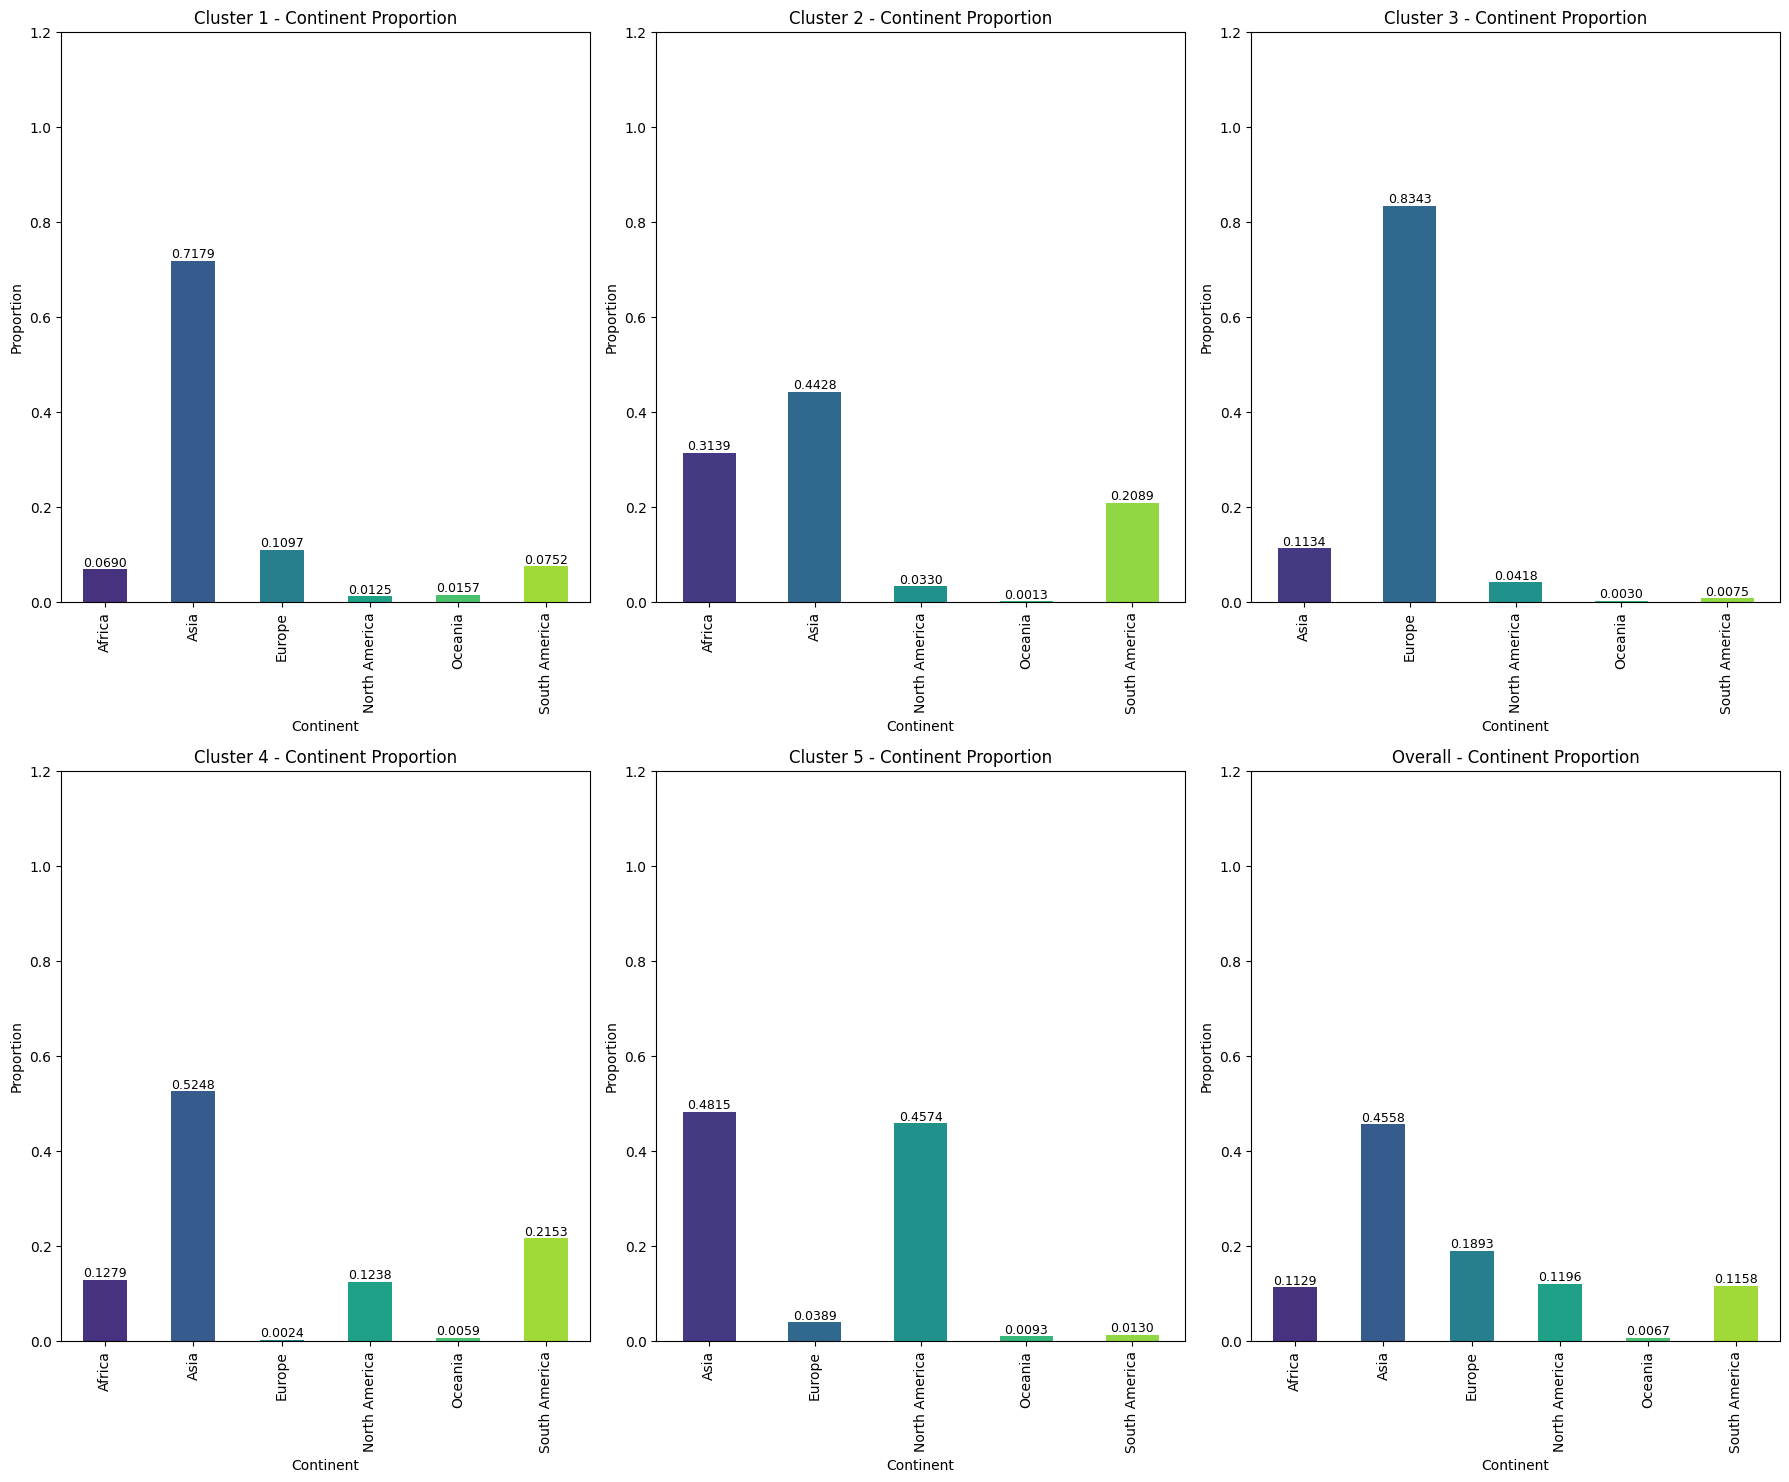

In [17]:
def add_labels(ax, values):
    for index, value in enumerate(values):
        ax.text(index, value, f"{value:.4f}", ha='center', va='bottom', fontsize=9, color='black')

n_clusters = len(np.sort(df_merged['Cluster'].unique()))

n_rows = int(np.ceil(n_clusters / 3)) + 1
fig, axs = plt.subplots(n_rows, 3, figsize=(18, n_rows * 7))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

# Cluster continent abundance
for i, cluster in enumerate(np.sort(df_merged['Cluster'].unique())):
    ax = axs.flat[i]
    cluster_continent_abundance = df_merged[df_merged['Cluster'] == cluster]['Continent'].value_counts(normalize=True).sort_index()
    
    cluster_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_continent_abundance)))
    cluster_label = 'Noise' if cluster == -1 else f'Cluster {cluster+1}'
    ax.set_title(f'{cluster_label} - Continent Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1.2)
    add_labels(ax, cluster_continent_abundance.values)

# overall continent abundance
ax = axs.flat[n_clusters]
overall_continent_abundance = df['Continent'].value_counts(normalize=True).sort_index()
overall_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_continent_abundance)))
ax.set_title('Overall - Continent Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1.2)
add_labels(ax, overall_continent_abundance.values)

# Hide any unused subplots
for i in range(n_clusters + 1, n_rows * 3):
    if i < len(axs.flat):
        fig.delaxes(axs.flat[i])

plt.tight_layout()
plt.show()

Relative abundance of Koppen climate classifications

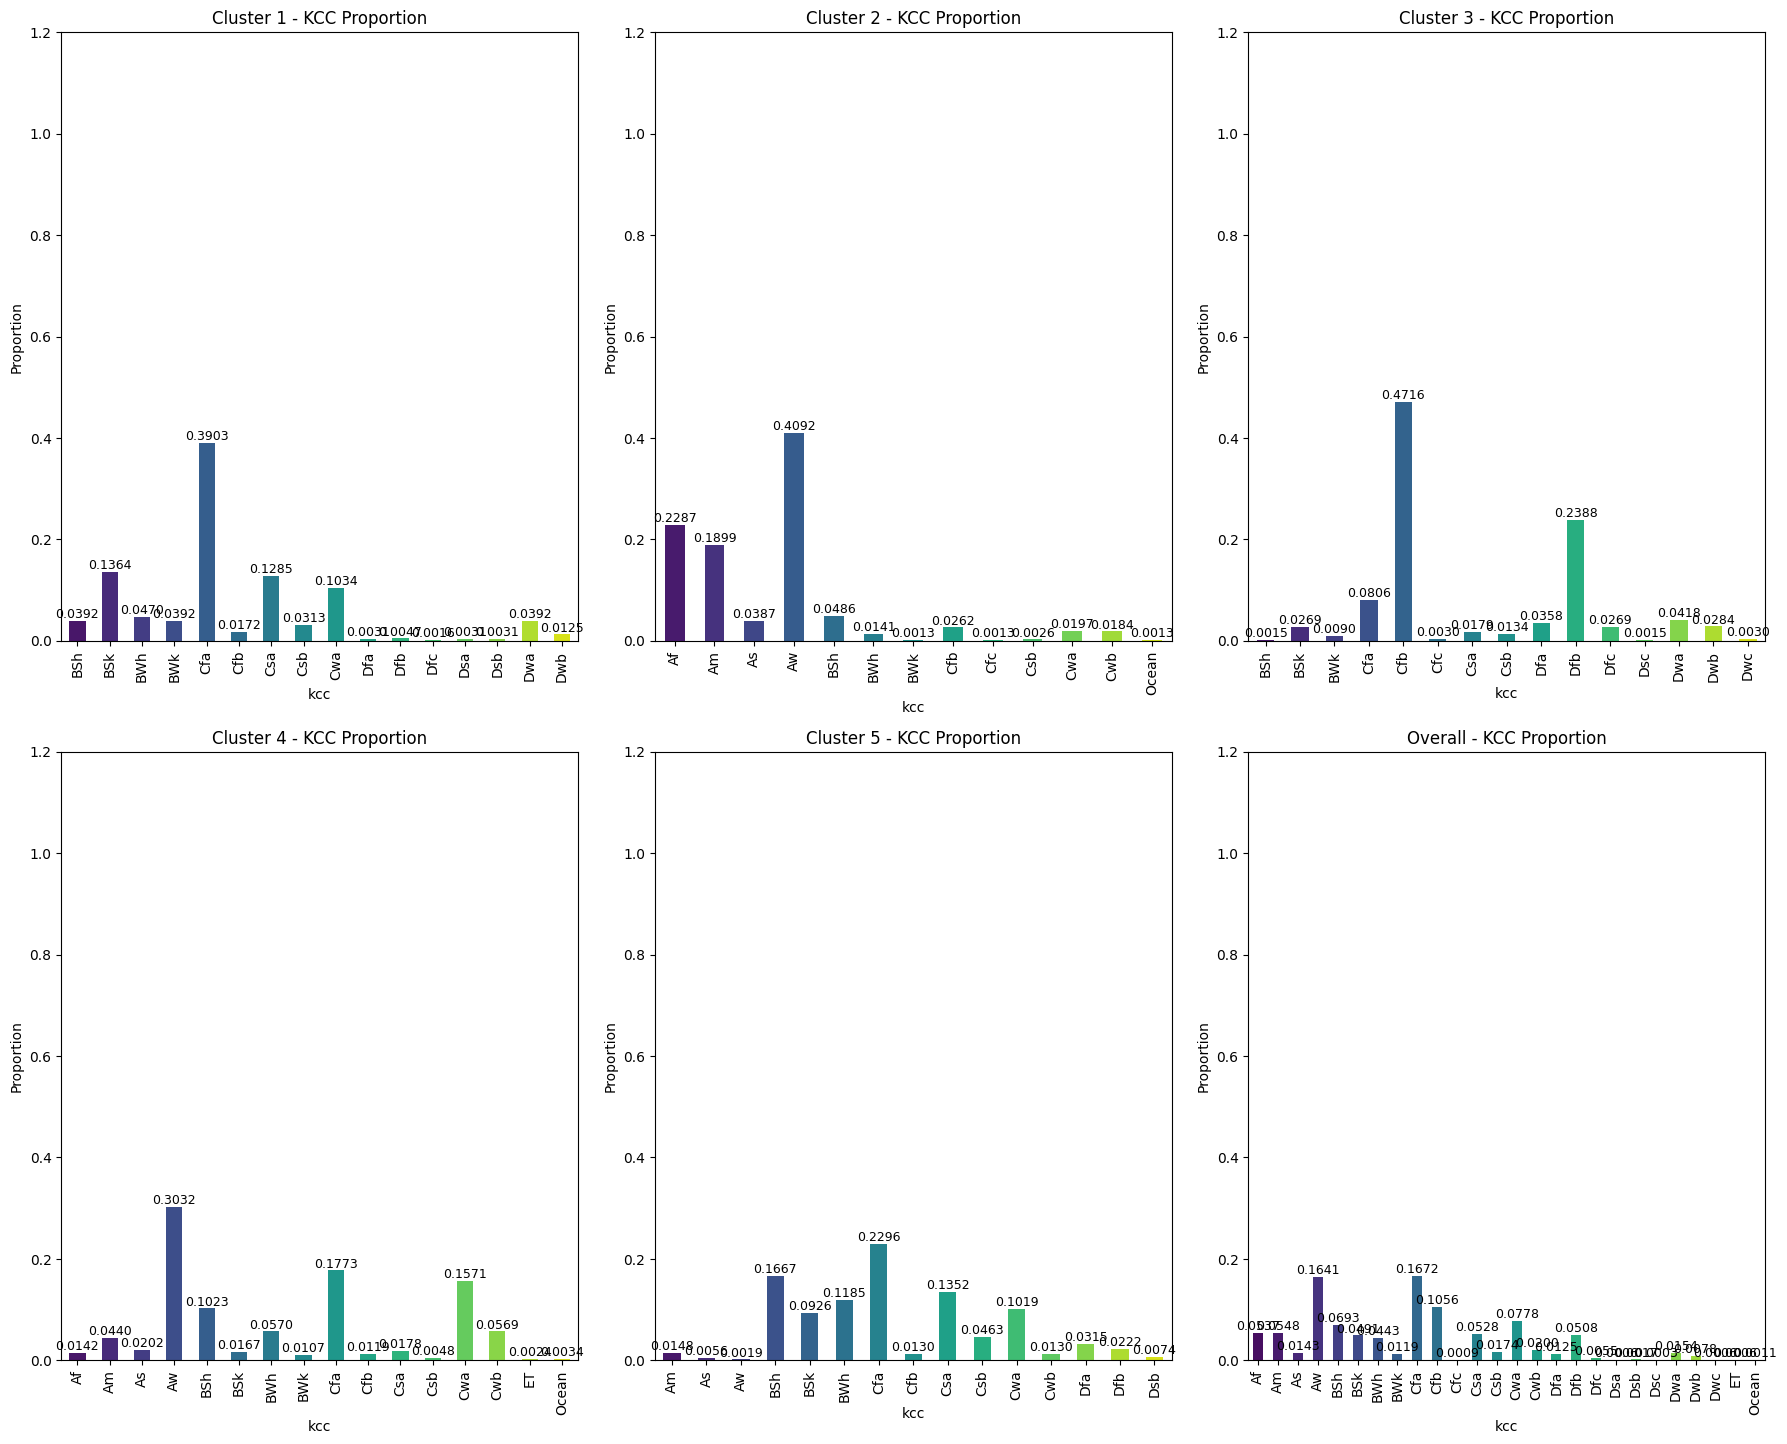

In [18]:
n_rows = int(np.ceil(n_clusters / 3)) + 1 
fig, axs = plt.subplots(n_rows, 3, figsize=(18, n_rows * 7))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

# Cluster KCC abundance
for i, cluster in enumerate(np.sort(df_merged['Cluster'].unique())):
    ax = axs.flat[i]
    cluster_kcc_abundance = df_merged[df_merged['Cluster'] == cluster]['kcc'].value_counts(normalize=True).sort_index()
    
    cluster_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_kcc_abundance)))
    cluster_label = 'Noise' if cluster == -1 else f'Cluster {cluster+1}'
    ax.set_title(f'{cluster_label} - KCC Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1.2)
    add_labels(ax, cluster_kcc_abundance.values)

# Overall KCC abundance
ax = axs.flat[n_clusters]
overall_kcc_abundance = df['kcc'].value_counts(normalize=True).sort_index()
overall_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_kcc_abundance)))
ax.set_title('Overall - KCC Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1.2)
add_labels(ax, overall_kcc_abundance.values)

for i in range(n_clusters + 1, n_rows * 3):
    if i < len(axs.flat):
        fig.delaxes(axs.flat[i])

plt.tight_layout()
plt.show()

Visualize as heatmaps

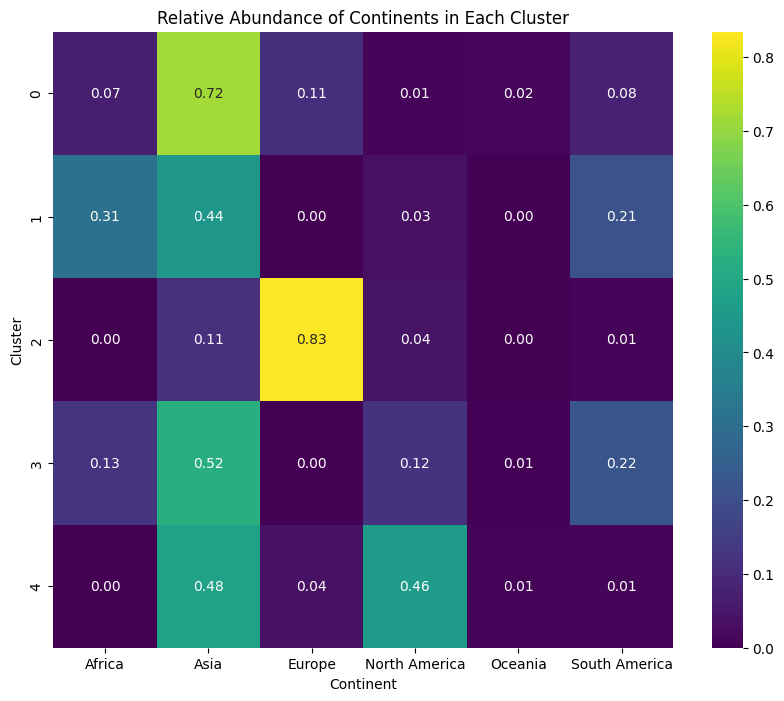

In [19]:
continent_cluster_proportion = pd.crosstab(df_merged['Cluster'], df_merged['Continent'], normalize='index')
plt.figure(figsize=(10, 8))
sns.heatmap(continent_cluster_proportion, annot=True, cmap='viridis', fmt=".2f")
plt.title('Relative Abundance of Continents in Each Cluster')
plt.xlabel('Continent')
plt.ylabel('Cluster')
plt.show()

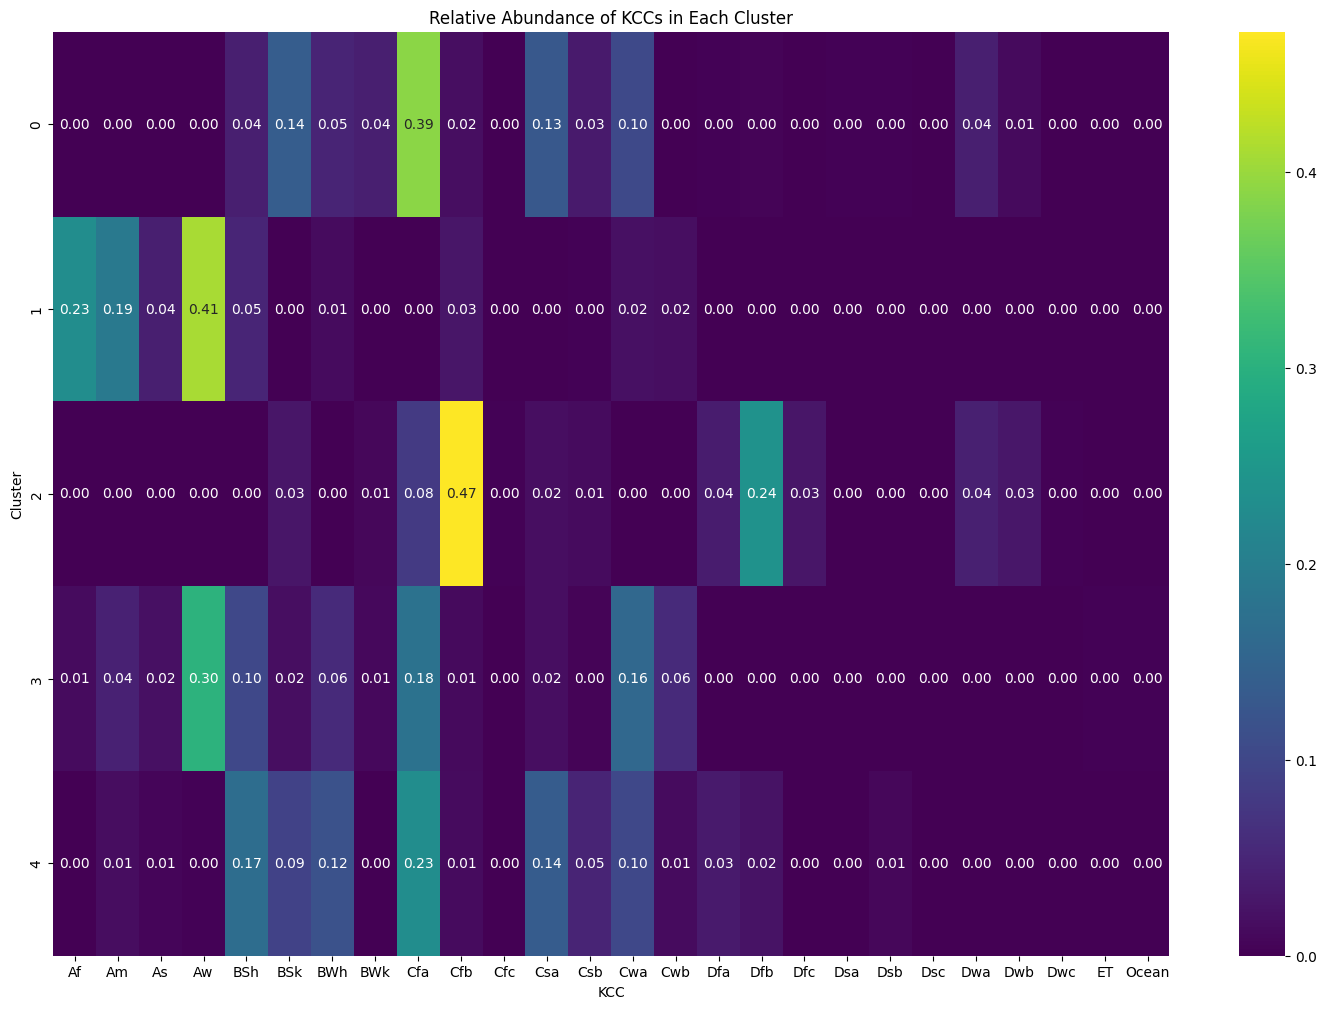

In [20]:
# Relative climate abundances
kcc_cluster_proportion = pd.crosstab(df_merged['Cluster'], df_merged['kcc'], normalize='index')
plt.figure(figsize=(18, 12))
sns.heatmap(kcc_cluster_proportion, annot=True, cmap='viridis', fmt=".2f")
plt.title('Relative Abundance of KCCs in Each Cluster')
plt.xlabel('KCC')
plt.ylabel('Cluster')
plt.show()

Visualization of geographic spread (Latitude, Longitude) for each cluster

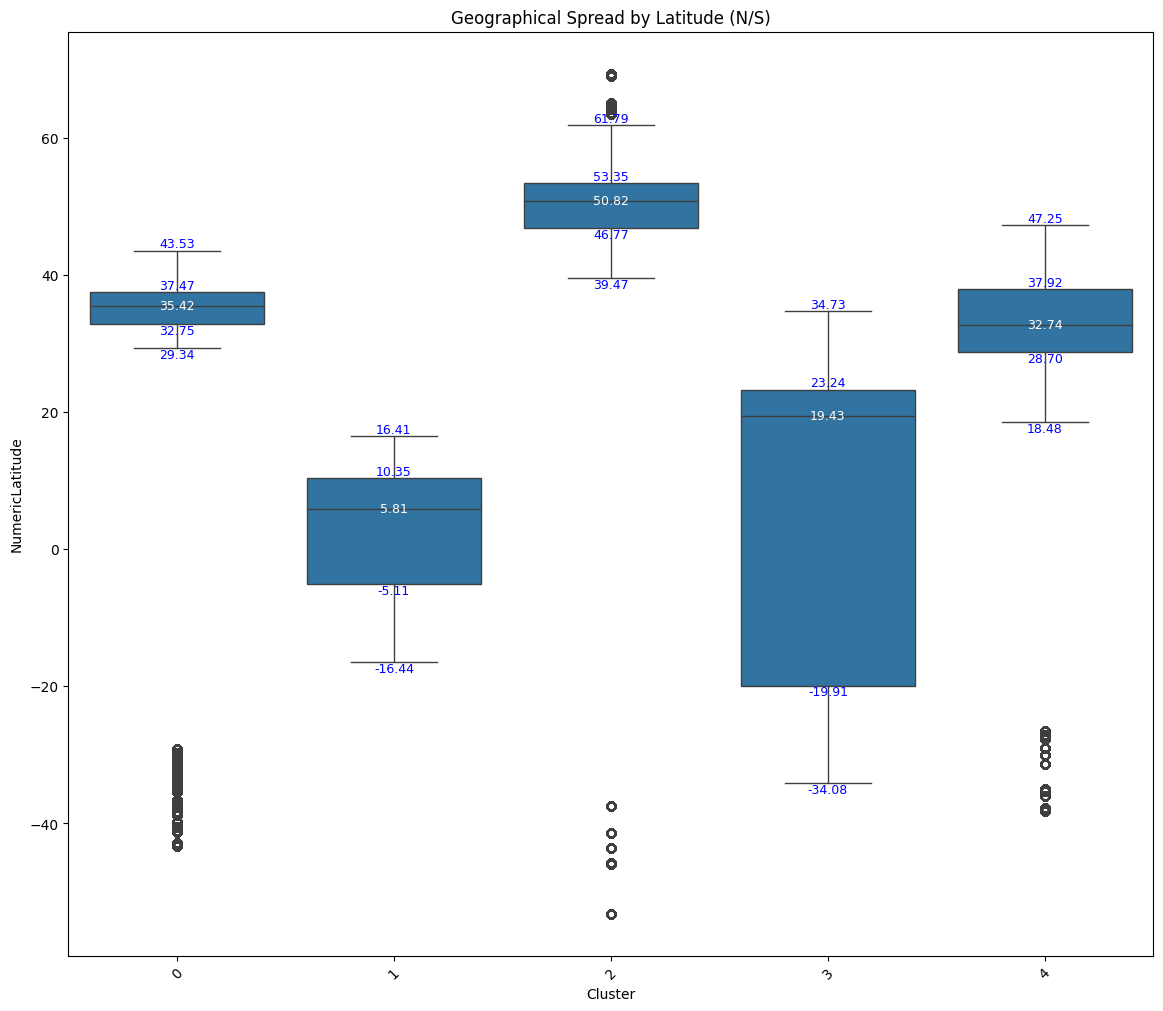

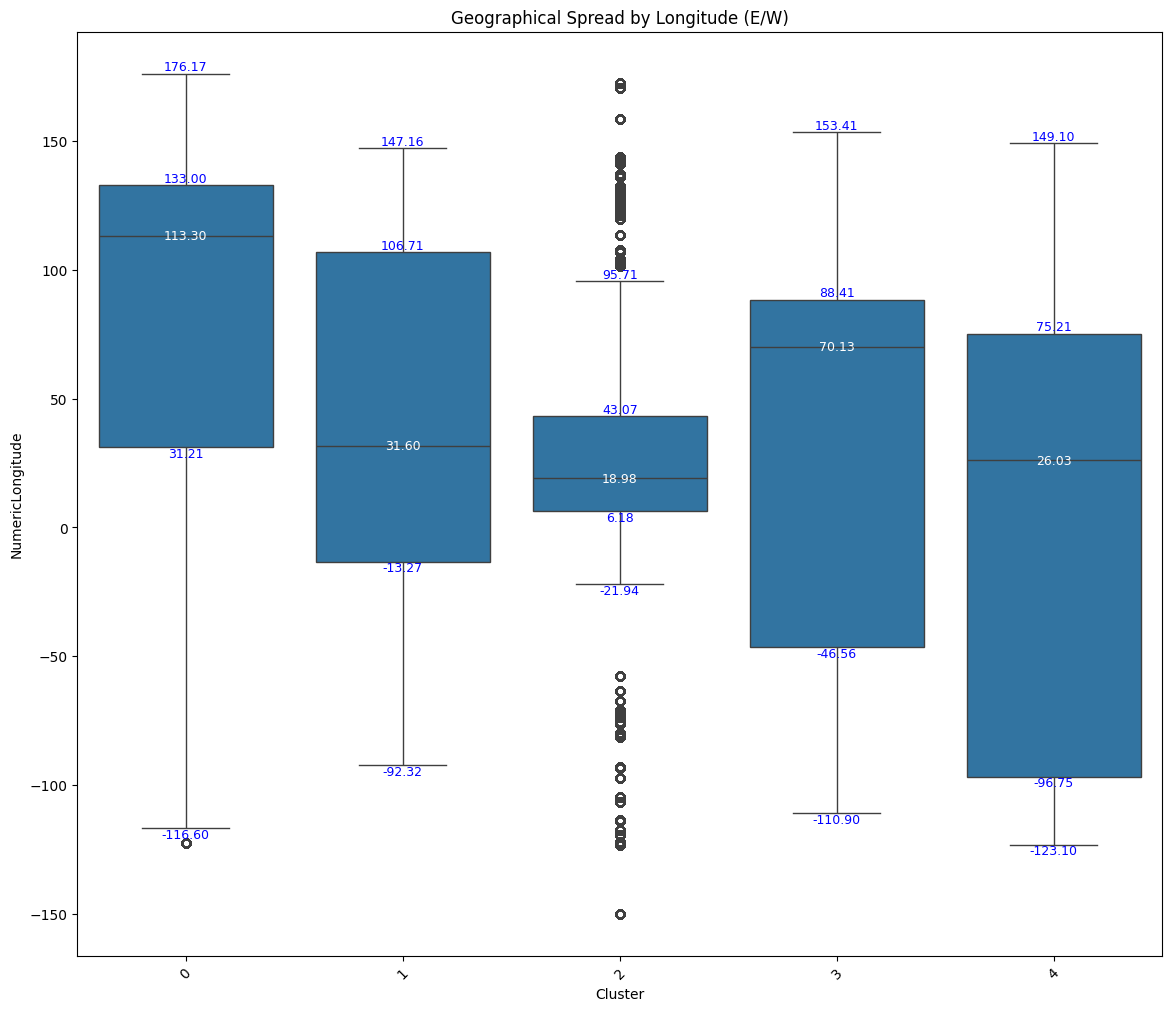

In [21]:
plt.figure(figsize=(14, 12))
sns.boxplot(x='Cluster', y='NumericLatitude', data=df_merged)

unique_clusters = np.sort(df_merged['Cluster'].unique())
for cluster in unique_clusters:
    cluster_latitudes = df_merged[df_merged['Cluster'] == cluster]['NumericLatitude']
    percentiles = np.percentile(cluster_latitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_latitudes[cluster_latitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_latitudes[cluster_latitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    cluster_index = np.where(unique_clusters == cluster)[0][0]  # Find the index of the cluster for plotting
    plt.text(cluster_index, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(cluster_index, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(cluster_index, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Latitude (N/S)')
plt.ylabel('NumericLatitude')
plt.xlabel('Cluster')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 12))
sns.boxplot(x='Cluster', y='NumericLongitude', data=df_merged)

for cluster in unique_clusters:
    cluster_longitudes = df_merged[df_merged['Cluster'] == cluster]['NumericLongitude']
    percentiles = np.percentile(cluster_longitudes, [25, 50, 75])
    lower_whisker = np.min(cluster_longitudes[cluster_longitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_longitudes[cluster_longitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    cluster_index = np.where(unique_clusters == cluster)[0][0]
    plt.text(cluster_index, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(cluster_index, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(cluster_index, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Longitude (E/W)')
plt.ylabel('NumericLongitude')
plt.xlabel('Cluster')
plt.xticks(rotation=45)
plt.show()